# MSc Data Science: (deep) discriminative models for **MNIST**

# Loading useful stuff

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from tensorflow.keras import initializers

tfk = tf.keras
tfkl = tf.keras.layers
tfd = tfp.distributions

#Loading and normalising MNIST

In [ ]:
(train_images, y_train), (test_images,  y_test) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28*28)
test_images = test_images.reshape(test_images.shape[0], 28*28)

y_train = tf.cast(y_train, tf.int32)
y_test =tf.cast(y_test, tf.int32)

11501568/11490434 [==============================] - 0s 0us/step


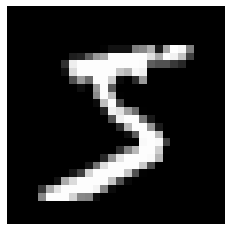

In [ ]:
plt.imshow(train_images[0, :].reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Normalizing the images to the range of [0., 1.]
train_images = train_images/255.
test_images = test_images/255.

# Logistic regression

Our goal is to build a classifier on MNIST. A first simple example of classifier is **logistic regression**, a particular case of **discriminative model**. The model for (multiclass) logistic regression is 
$$ p (y | \mathbf{x} ) = \text{Cat} (y |\text{Softmax}(\mathbf{W}\mathbf{x}+\mathbf{b})),$$
where the unknown parameters are $\mathbf{W}$ and $\mathbf{b}$.

**Question 1.** What are the dimensions of $\mathbf{W}$ and $\mathbf{b}$? What is the total number of parameters in the model?

We will build our logistic regression model using [**keras**](https://keras.io/), a nice deep learning API. In particular, keras's [sequential model](https://keras.io/guides/sequential_model/) is simple way of building compositions of parametric functions.

In [ ]:
logistic_regression = tfk.Sequential([
  tfkl.InputLayer(input_shape=[28*28,]),
  tfkl.Dense(10, kernel_initializer=initializers.RandomNormal(stddev=1)) # because we have 10 classes
])

Here, $\texttt{logistic_regression}$ represents the function $ \mathbf{x} \mapsto \mathbf{W}\mathbf{x}+\mathbf{b}$, that takes vectors as inputs, and returns probabilities for each class. We can try with the first MNIST image. The model is initialised by sampling each coefficient of $\mathbf{W}$ from a standard Gaussian distribution.

In [ ]:
logistic_regression(train_images[0:1,])

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[  8.495928  ,   5.488267  ,  20.32993   ,  -3.6566849 ,
         -3.0612555 ,   5.8395925 ,  -3.9733167 ,   1.7556076 ,
         -0.06998014, -11.785327  ]], dtype=float32)>

Note that the output is a Tensorflow tensor. One can easily get a Numpy array instead this way:

In [ ]:
logistic_regression(train_images[0:1,]).numpy()

array([[  8.495928  ,   5.488267  ,  20.32993   ,  -3.6566849 ,
         -3.0612555 ,   5.8395925 ,  -3.9733167 ,   1.7556076 ,
         -0.06998014, -11.785327  ]], dtype=float32)

This $\texttt{logistic_regression}$ conveniently can also handle **batches** of inputs. Here we look at the predictions of the 10 first digits of MNIST.

In [ ]:
logistic_regression(train_images[0:10,]).numpy()

array([[ 8.4959307e+00,  5.4882679e+00,  2.0329935e+01, -3.6566839e+00,
        -3.0612559e+00,  5.8395915e+00, -3.9733174e+00,  1.7556089e+00,
        -6.9981225e-02, -1.1785323e+01],
       [ 1.2374611e+00,  5.0504885e+00,  1.3919871e+01,  1.8583012e+01,
        -7.7279681e-01,  7.7924519e+00,  3.0808744e+00,  6.1116562e+00,
        -9.3280048e+00,  4.9655461e+00],
       [-7.2871075e+00, -1.5397094e+01, -1.0909403e+01,  7.9048395e+00,
         6.6938150e-01, -1.1753743e+01, -1.0543722e+01,  4.1888528e+00,
        -1.2670908e+01, -9.9815159e+00],
       [ 9.8974733e+00,  5.1582203e+00,  1.2600046e+01,  7.4502740e+00,
        -1.0253202e+01, -5.3853106e+00, -1.7099901e+01, -7.8233685e+00,
        -2.9905379e+00,  7.6379871e+00],
       [-6.8080902e+00, -8.9221420e+00, -1.5757835e+00,  3.5098949e-03,
        -1.2371784e+00, -1.3925304e+01, -5.5616784e+00, -6.6310763e-01,
        -1.0669029e+01, -1.0636754e+00],
       [ 4.1798277e+00,  1.1117022e+00,  1.6029219e+01,  6.1082716e+00,
   

One can check that each row of these predictions sums to one:

In [ ]:
np.sum(logistic_regression(train_images[0:10,]).numpy(),1)

array([ 19.362774 ,  50.640556 , -65.78042  ,  -0.8083191, -50.422478 ,
         3.3333173, -54.16128  ,  -5.146389 , -29.785133 , -11.733627 ],
      dtype=float32)

One can us Tensorflow Probability to create the distribution  $p (y | \mathbf{x} )$

In [ ]:
p_ygivenx_logistic_regression = tfd.Categorical(logits = logistic_regression(train_images[0:10,]))

In [ ]:
p_ygivenx_logistic_regression.sample() # sampling the predicted labels

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([8, 0, 2, 4, 2, 8, 3, 0, 7, 0], dtype=int32)>

In [ ]:
p_ygivenx_logistic_regression.mode() # looking at the most probable labels

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 0, 3, 8, 8, 8, 3, 0, 8, 0], dtype=int32)>

# Training the logistic regression model

To train the classifier, we define a function that performs a gradient descent step. First, we choose the flavour of SGD that we want (in this case, the [fairly famous Adam](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)).

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005)

In [ ]:
@tf.function
def train_step_logistic_regression(data, labels):
  with tf.GradientTape() as tape: # the gradient tape saves all the step that needs to be saved fopr automatic differentiation
    p_ygivenx_logistic_regression = tfd.Categorical(logits = logistic_regression(data)) # One could also use logits rather than probs and remove the softmax layer...
    logp_ygivenx_logistic_regression = p_ygivenx_logistic_regression.log_prob(labels)
    loss = -tf.reduce_mean(logp_ygivenx_logistic_regression)  # the loss is the average negative log likelihood
  gradients = tape.gradient(loss, logistic_regression.trainable_variables)  # here, the gradient is automatically computed
  optimizer.apply_gradients(zip(gradients, logistic_regression.trainable_variables))  # Adam iteration

In [ ]:
@tf.function
def evaluate_logistic_regression(data, labels):
  p_ygivenx_logistic_regression = tfd.Categorical(logits = logistic_regression(data))
  logp_ygivenx_logistic_regression = p_ygivenx_logistic_regression.log_prob(labels)
  log_likelihood = tf.reduce_mean(logp_ygivenx_logistic_regression)
  y_pred = p_ygivenx_logistic_regression.mode()
  acc = tf.reduce_mean(tf.cast(y_pred == labels,tf.float32))
  return acc, log_likelihood

In [ ]:
 evaluate_logistic_regression(train_images,y_train)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.09393334>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-13.758713>)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images,y_train)).shuffle(60000).batch(32) # TF creates the batches for us

In [ ]:
EPOCHS = 10

for epoch in range(1,EPOCHS+1):
  for images, labels in train_dataset:
    train_step_logistic_regression(images, labels) # Adam iteration
  acc, log_likelihood = evaluate_logistic_regression(train_images,y_train)
  acc_test, log_likelihood_test = evaluate_logistic_regression(test_images,y_test)
  print('Epoch  %g' %epoch)
  print('Train accuracy  %g' %acc.numpy())
  print('Test accuracy  %g' %acc_test.numpy())
  print('Train log-likelihood  %g' %log_likelihood.numpy())
  print('Test log-likelihood  %g' %log_likelihood_test.numpy())
  print('-----------')

Epoch  1
Train accuracy  0.1246
Test accuracy  0.1305
Train log-likelihood  -9.50821
Test log-likelihood  -9.32266
-----------
Epoch  2
Train accuracy  0.189433
Test accuracy  0.2023
Train log-likelihood  -7.02632
Test log-likelihood  -6.82459
-----------
Epoch  3
Train accuracy  0.284317
Test accuracy  0.2963
Train log-likelihood  -5.36089
Test log-likelihood  -5.16961
-----------
Epoch  4
Train accuracy  0.380383
Test accuracy  0.3898
Train log-likelihood  -4.25872
Test log-likelihood  -4.0787
-----------
Epoch  5
Train accuracy  0.455667
Test accuracy  0.4668
Train log-likelihood  -3.50228
Test log-likelihood  -3.33061
-----------
Epoch  6
Train accuracy  0.517217
Test accuracy  0.5274
Train log-likelihood  -2.96103
Test log-likelihood  -2.80156
-----------
Epoch  7
Train accuracy  0.565583
Test accuracy  0.5775
Train log-likelihood  -2.56338
Test log-likelihood  -2.4147
-----------
Epoch  8
Train accuracy  0.605117
Test accuracy  0.6177
Train log-likelihood  -2.26202
Test log-likel

**Question 2.** Compare the results of your logistic regression classifier with the ones given by scikit-learn's logistic regression.

**Question 3.** Replace the logistic regression model by a deep classifier of your choice (e.g. a MLP or a CNN). Try to beat logistic regression!